<a href="https://colab.research.google.com/github/Atharva-130405/Stock_Market_Anamoly/blob/main/CapstoneProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Packages loaded successfully

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data folder found: /content/drive/MyDrive/DATA SCIENCE PROJECT

AAPL: 9909 rows
MSFT: 8584 rows
AMZN: 5758 rows
NVDA: 5334 rows

Loaded 4 stocks

Total observations: 29265
Date range: 1981-03-17 to 2020-04-01

Train (2018): 1004
Val (2019): 1008
Test (2020 Q1): 248

Features scaled

K-Means: k=3

DBSCAN: 1 clusters, 140 noise points

K-Means: 11 anomalies
DBSCAN: 31 anomalies
Combined: 32 anomalies

Saved: daily_anomaly_card.csv
Saved: market_day_table.csv



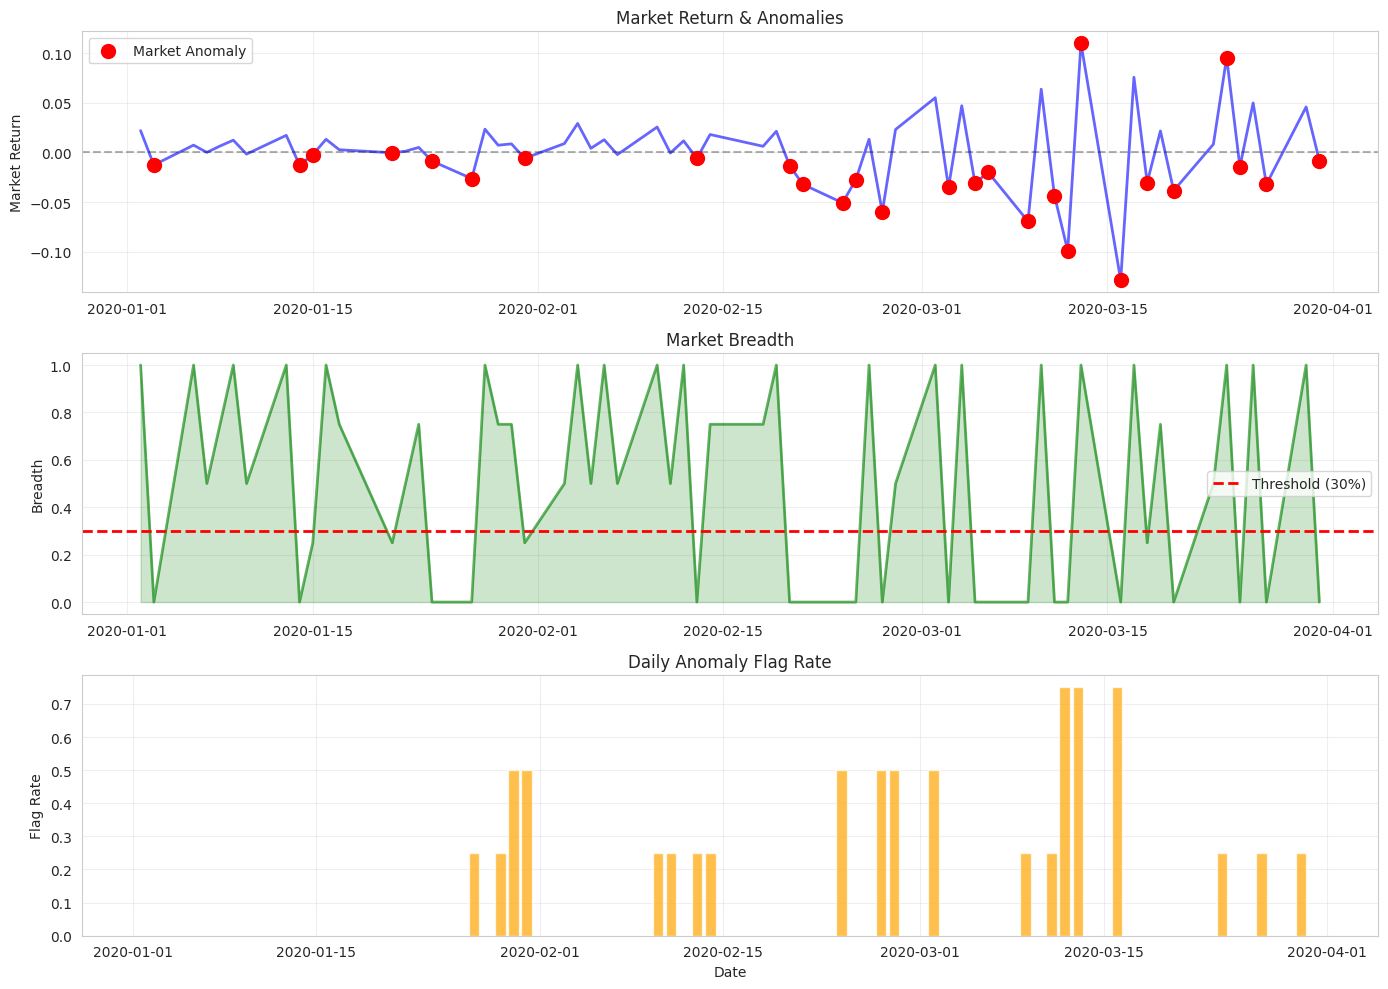

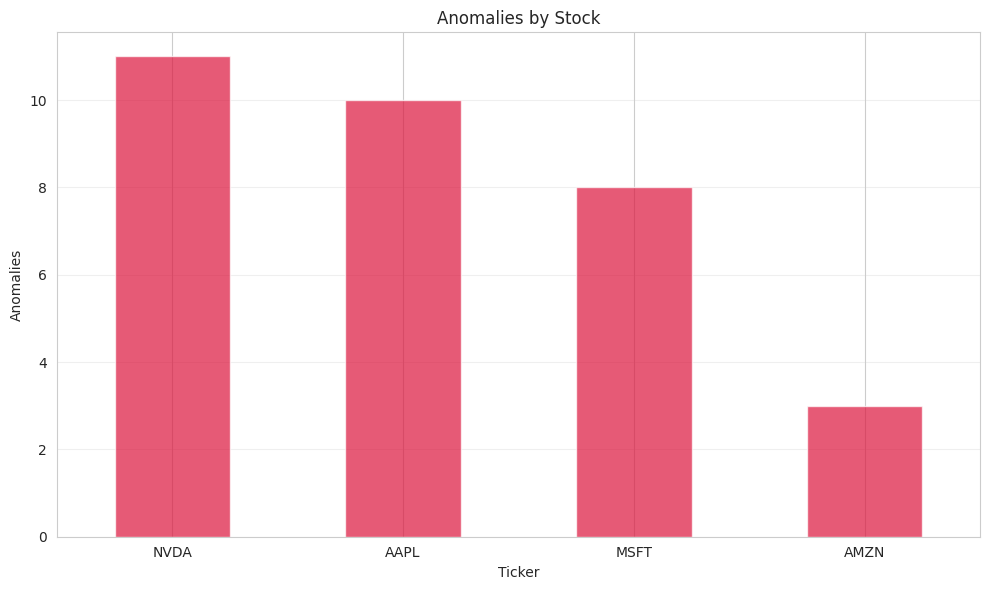

Saved: market_analysis.png
Saved: anomalies_by_ticker.png


Date: 2020-02-27
Market Return: -5.99%
Breadth: 0.0%
Flag Rate: 50.0%
Market Anomaly: YES

Anomalous stocks (2):

AAPL:
  Type: crash+volume_shock
  Return: -6.54%
  ret_z: -4.13
  volz: 2.68

MSFT:
  Type: crash+volume_shock
  Return: -7.05%
  ret_z: -5.32
  volz: 2.87

Date: 2020-03-12
Market Return: -9.88%
Breadth: 0.0%
Flag Rate: 75.0%
Market Anomaly: YES

Anomalous stocks (3):

MSFT:
  Type: crash
  Return: -9.48%
  ret_z: -3.87
  volz: 1.46

AMZN:
  Type: crash
  Return: -7.92%
  ret_z: -3.77
  volz: 2.04

NVDA:
  Type: crash
  Return: -12.24%
  ret_z: -3.92
  volz: 0.59

Date: 2020-03-16
Market Return: -12.86%
Breadth: 0.0%
Flag Rate: 75.0%
Market Anomaly: YES

Anomalous stocks (3):

AAPL:
  Type: crash
  Return: -12.86%
  ret_z: -3.89
  volz: 0.83

MSFT:
  Type: crash
  Return: -14.74%
  ret_z: -4.53
  volz: 1.06

NVDA:
  Type: crash
  Return: -18.45%
  ret_z: -4.88
  volz: 0.06


Summary:
Total observations: 248
Anoma

In [ ]:
!pip install -q scikit-learn pandas numpy matplotlib seaborn scipy

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from google.colab import drive
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("Packages loaded successfully\n")

drive.mount('/content/drive')

DATA_FOLDER = '/content/drive/MyDrive/DATA SCIENCE PROJECT'
STOCKS_FOLDER = os.path.join(DATA_FOLDER, 'stocks')

if not os.path.exists(STOCKS_FOLDER):
    raise FileNotFoundError(f"Folder not found: {STOCKS_FOLDER}")

print(f"Data folder found: {DATA_FOLDER}\n")

TICKERS = ['QQQ', 'AAPL', 'MSFT', 'AMZN', 'NVDA', 'META']

stock_data = {}

for ticker in TICKERS:
    file_path = os.path.join(STOCKS_FOLDER, f"{ticker}.csv")

    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date').reset_index(drop=True)
        stock_data[ticker] = df
        print(f"{ticker}: {len(df)} rows")

print(f"\nLoaded {len(stock_data)} stocks\n")

def calculate_features(df, ticker_name):
    df = df.copy()
    df['ticker'] = ticker_name

    df['return'] = df['Adj Close'].pct_change()
    df['log_volume'] = np.log(df['Volume'] + 1)
    df['intraday_range'] = (df['High'] - df['Low']) / df['Close']

    df['return_mean'] = df['return'].shift(1).rolling(63, min_periods=63).mean()
    df['return_std'] = df['return'].shift(1).rolling(63, min_periods=63).std()
    df['volume_mean'] = df['log_volume'].shift(1).rolling(21, min_periods=21).mean()
    df['volume_std'] = df['log_volume'].shift(1).rolling(21, min_periods=21).std()

    df['ret_z'] = (df['return'] - df['return_mean']) / (df['return_std'] + 1e-8)
    df['volz'] = (df['log_volume'] - df['volume_mean']) / (df['volume_std'] + 1e-8)

    def calculate_percentile(series, window=63):
        percentiles = []
        for i in range(len(series)):
            if i < window:
                percentiles.append(np.nan)
            else:
                past_values = series.iloc[i-window:i].values
                current_value = series.iloc[i]
                pct = stats.percentileofscore(past_values, current_value)
                percentiles.append(pct)
        return percentiles

    df['range_pct'] = calculate_percentile(df['intraday_range'])
    df['valid'] = ~(df['ret_z'].isna() | df['volz'].isna() | df['range_pct'].isna())

    return df

all_data = []

for ticker, df in stock_data.items():
    df_features = calculate_features(df, ticker)
    all_data.append(df_features)

combined_data = pd.concat(all_data, ignore_index=True)
combined_data = combined_data[combined_data['valid']].copy()

print(f"Total observations: {len(combined_data)}")
print(f"Date range: {combined_data['Date'].min().date()} to {combined_data['Date'].max().date()}\n")

train_data = combined_data[combined_data['Date'].dt.year == 2018].copy()
val_data = combined_data[combined_data['Date'].dt.year == 2019].copy()
test_data = combined_data[(combined_data['Date'].dt.year == 2020) &
                          (combined_data['Date'].dt.month <= 3)].copy()

print(f"Train (2018): {len(train_data)}")
print(f"Val (2019): {len(val_data)}")
print(f"Test (2020 Q1): {len(test_data)}\n")

feature_columns = ['ret_z', 'volz', 'range_pct']

X_train = train_data[feature_columns].values
X_val = val_data[feature_columns].values
X_test = test_data[feature_columns].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Features scaled\n")

best_k = 5
best_score = -1

for k in range(3, 8):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_train_scaled)
    score = silhouette_score(X_train_scaled, labels)

    if score > best_score:
        best_score = score
        best_k = k

print(f"K-Means: k={best_k}\n")

kmeans_model = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_model.fit(X_train_scaled)

train_labels = kmeans_model.predict(X_train_scaled)
train_distances = np.linalg.norm(X_train_scaled - kmeans_model.cluster_centers_[train_labels], axis=1)

cluster_thresholds = {}
for cluster_id in range(best_k):
    cluster_dists = train_distances[train_labels == cluster_id]
    threshold = np.percentile(cluster_dists, 97.5)
    cluster_thresholds[cluster_id] = threshold

dbscan_model = DBSCAN(eps=0.5, min_samples=15)
dbscan_labels = dbscan_model.fit_predict(X_train_scaled)

n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"DBSCAN: {n_clusters} clusters, {n_noise} noise points\n")

test_kmeans_labels = kmeans_model.predict(X_test_scaled)
test_kmeans_distances = np.linalg.norm(X_test_scaled - kmeans_model.cluster_centers_[test_kmeans_labels], axis=1)

test_kmeans_anomalies = np.zeros(len(X_test_scaled), dtype=int)
for i, (label, dist) in enumerate(zip(test_kmeans_labels, test_kmeans_distances)):
    if dist > cluster_thresholds[label]:
        test_kmeans_anomalies[i] = 1

X_history = np.vstack([X_train_scaled, X_val_scaled])
X_combined = np.vstack([X_history, X_test_scaled])

dbscan_test = DBSCAN(eps=0.5, min_samples=15)
all_labels = dbscan_test.fit_predict(X_combined)
test_dbscan_labels = all_labels[len(X_history):]

test_dbscan_anomalies = (test_dbscan_labels == -1).astype(int)

test_data['kmeans_anomaly'] = test_kmeans_anomalies
test_data['kmeans_distance'] = test_kmeans_distances
test_data['dbscan_anomaly'] = test_dbscan_anomalies
test_data['anomaly'] = ((test_data['kmeans_anomaly'] == 1) |
                        (test_data['dbscan_anomaly'] == 1)).astype(int)

print(f"K-Means: {test_kmeans_anomalies.sum()} anomalies")
print(f"DBSCAN: {test_dbscan_anomalies.sum()} anomalies")
print(f"Combined: {test_data['anomaly'].sum()} anomalies\n")

test_data['type'] = ''

crash_mask = (test_data['return'] < 0) & (np.abs(test_data['ret_z']) > 2.5)
test_data.loc[crash_mask, 'type'] = 'crash'

spike_mask = (test_data['return'] > 0) & (np.abs(test_data['ret_z']) > 2.5)
test_data.loc[spike_mask, 'type'] = 'spike'

vol_shock_mask = np.abs(test_data['volz']) > 2.5
test_data.loc[vol_shock_mask & (test_data['type'] != ''), 'type'] += '+volume_shock'
test_data.loc[vol_shock_mask & (test_data['type'] == ''), 'type'] = 'volume_shock'

test_data['why'] = ''
test_data.loc[np.abs(test_data['ret_z']) > 2.5, 'why'] += '|ret_z|>2.5; '
test_data.loc[np.abs(test_data['volz']) > 2.5, 'why'] += 'volz>2.5; '
test_data.loc[test_data['range_pct'] > 95, 'why'] += 'range_pct>95; '

market_stats = test_data.groupby('Date').agg({
    'return': 'mean',
    'anomaly': 'sum',
    'ticker': 'count'
}).reset_index()

market_stats.columns = ['date', 'market_ret', 'anomalies_count', 'total_tickers']
market_stats['flag_rate'] = market_stats['anomalies_count'] / market_stats['total_tickers']

breadth_list = []
for date in market_stats['date']:
    date_data = test_data[test_data['Date'] == date]
    breadth = (date_data['return'] > 0).sum() / len(date_data)
    breadth_list.append(breadth)

market_stats['breadth'] = breadth_list

market_ret_threshold = np.percentile(np.abs(market_stats['market_ret']), 95)
market_stats['market_anomaly'] = (
    (np.abs(market_stats['market_ret']) > market_ret_threshold) |
    (market_stats['breadth'] < 0.3)
).astype(int)

anomalies_only = test_data[test_data['anomaly'] == 1].copy()
anomaly_card = anomalies_only[['Date', 'ticker', 'anomaly', 'type', 'return',
                                'ret_z', 'volz', 'range_pct', 'why']].copy()
anomaly_card.columns = ['date', 'ticker', 'anomaly_flag', 'type', 'ret',
                        'ret_z', 'volz', 'range_pct', 'why']
anomaly_card['date'] = anomaly_card['date'].dt.strftime('%Y-%m-%d')
anomaly_card = anomaly_card.round(3)
anomaly_card.to_csv('daily_anomaly_card.csv', index=False)

market_table = market_stats[['date', 'market_ret', 'breadth', 'market_anomaly']].copy()
market_table.columns = ['date', 'market_ret', 'breadth', 'market_anomaly_flag']
market_table['date'] = market_table['date'].dt.strftime('%Y-%m-%d')
market_table = market_table.round(4)
market_table.to_csv('market_day_table.csv', index=False)

print("Saved: daily_anomaly_card.csv")
print("Saved: market_day_table.csv\n")

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

ax = axes[0]
ax.plot(market_stats['date'], market_stats['market_ret'], 'b-', alpha=0.6, linewidth=2)
anomaly_days = market_stats[market_stats['market_anomaly'] == 1]
ax.scatter(anomaly_days['date'], anomaly_days['market_ret'],
          c='red', s=100, marker='o', label='Market Anomaly', zorder=5)
ax.axhline(0, color='black', linestyle='--', alpha=0.3)
ax.set_ylabel('Market Return')
ax.set_title('Market Return & Anomalies')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(market_stats['date'], market_stats['breadth'], 'g-', alpha=0.6, linewidth=2)
ax.axhline(0.3, color='red', linestyle='--', label='Threshold (30%)', linewidth=2)
ax.fill_between(market_stats['date'], 0, market_stats['breadth'], alpha=0.2, color='green')
ax.set_ylabel('Breadth')
ax.set_title('Market Breadth')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[2]
ax.bar(market_stats['date'], market_stats['flag_rate'], alpha=0.7, color='orange')
ax.set_ylabel('Flag Rate')
ax.set_title('Daily Anomaly Flag Rate')
ax.set_xlabel('Date')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('market_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
anomaly_counts = test_data[test_data['anomaly'] == 1].groupby('ticker').size().sort_values(ascending=False)
anomaly_counts.plot(kind='bar', color='crimson', alpha=0.7)
plt.ylabel('Anomalies')
plt.xlabel('Ticker')
plt.title('Anomalies by Stock')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('anomalies_by_ticker.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: market_analysis.png")
print("Saved: anomalies_by_ticker.png\n")

def query_date(date_string):
    query_date = pd.to_datetime(date_string)

    print(f"\nDate: {date_string}")

    market_row = market_stats[market_stats['date'] == query_date]

    if len(market_row) == 0:
        print("No data for this date")
        return

    market_row = market_row.iloc[0]

    print(f"Market Return: {market_row['market_ret']:.2%}")
    print(f"Breadth: {market_row['breadth']:.1%}")
    print(f"Flag Rate: {market_row['flag_rate']:.1%}")
    print(f"Market Anomaly: {'YES' if market_row['market_anomaly'] else 'NO'}")

    date_anomalies = test_data[(test_data['Date'] == query_date) & (test_data['anomaly'] == 1)]

    if len(date_anomalies) == 0:
        print("No anomalous stocks")
    else:
        print(f"\nAnomalous stocks ({len(date_anomalies)}):")

        for _, row in date_anomalies.iterrows():
            print(f"\n{row['ticker']}:")
            print(f"  Type: {row['type']}")
            print(f"  Return: {row['return']:.2%}")
            print(f"  ret_z: {row['ret_z']:.2f}")
            print(f"  volz: {row['volz']:.2f}")

query_date('2020-02-27')
query_date('2020-03-12')
query_date('2020-03-16')

print(f"\n\nSummary:")
print(f"Total observations: {len(test_data)}")
print(f"Anomalies: {test_data['anomaly'].sum()} ({test_data['anomaly'].mean()*100:.1f}%)")
print(f"Market anomaly days: {market_stats['market_anomaly'].sum()}/{len(market_stats)}")
print("\nProject complete")